<a href="https://colab.research.google.com/github/sumanjitmoshat/Attention-Model/blob/master/Eye_for_blind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [121]:
#Import all the required libraries
import glob
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image as PImage
import os
import pandas as pd
from collections import Counter
import seaborn as sns
from keras.preprocessing.text import Tokenizer
import operator
import tensorflow as tf
import keras
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
import time
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image

Let's read the dataset

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d adityajn105/flickr8k
! mkdir train
! unzip flickr8k.zip -d train

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-18 20:55:49           7818  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4760  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1595  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-06-09 15:58:24           2257  
fatiimaezzahra/f

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the image into a seperate variable

images='/content/train/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


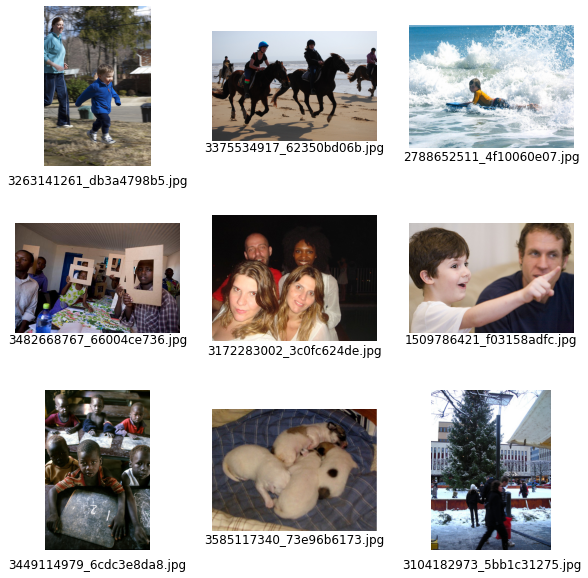

In [4]:
#Visualise both the images & text present in the dataset
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,1+i)
    imgpath = all_imgs[i]
    img = PImage.open(imgpath)
    plt.imshow(img)
    plt.title(os.path.split(imgpath)[-1], y=-0.15)
    plt.axis('off')

In [5]:
#Import the dataset and read the text file into a seperate variable
caption_txt = '/content/train/captions.txt'
def load_doc(filename):
    
    captions = open(filename).read()
    return captions

doc = load_doc(caption_txt)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [6]:
# creating lists for 
img_ids=[]
image_paths=[]
captions=[]
doc = doc.splitlines()[1:]
for line in doc:
  delimter_index = line.index(',')
  img_id,img_cap = line[:delimter_index],line[delimter_index+1:]
  img_ids.append(img_id)
  captions.append(img_cap)
  image_paths.append(images+'/'+img_id)



Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
all_img_id= img_ids#store all the image id here
all_img_vector= image_paths#store all the image path here
annotations= captions#store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/train/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/train/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/train/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/train/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/train/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/content/train/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/content/train/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/content/train/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/content/train/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [8]:
#Create a list which contains all the captions
annotations=['<start> '  + s + ' <end>' for s in list(df.Captions) ] #write your code here

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=list(df.Captions)#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [9]:
#Create the vocabulary & the counter for the captions

vocabulary= []#write your code here
for sent in df['Captions']:
  vocabulary += sent.split(' ')

val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

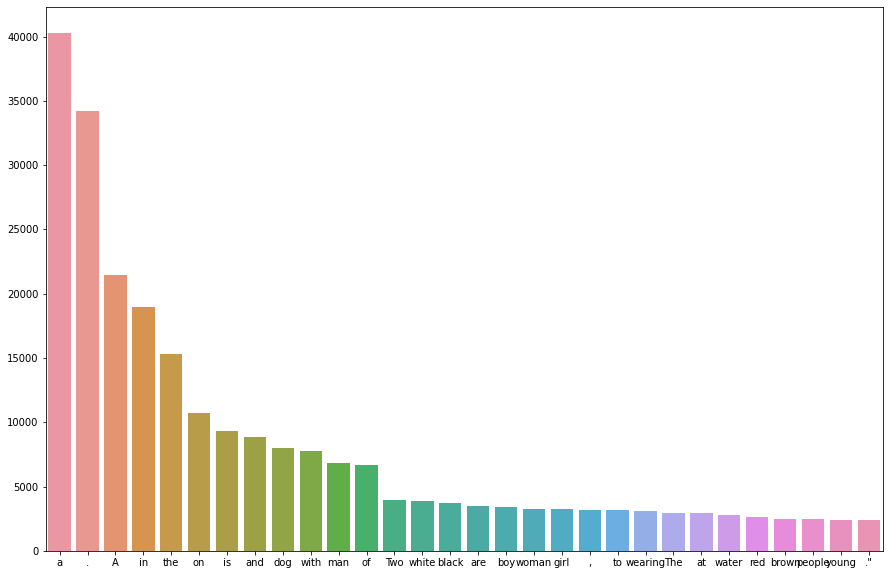

In [10]:
#Visualise the top 30 occuring words in the captions
#write your code here
top_thirty = val_count.most_common(30)
all_words = list(zip(*top_thirty))[0]
word_counts  = list(zip(*top_thirty))[1]
plt.figure(figsize=(15,10))
sns.barplot(x=list(all_words),y=list(word_counts))

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [11]:
# create the tokenizer
top_count = 5000
tokenizer_words =  Tokenizer(num_words=top_count,oov_token='<unk>',filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer_words.fit_on_texts(annotations)
train_seqs=tokenizer_words.texts_to_sequences(annotations)
#your code here

In [12]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [13]:
# Create word-to-index and index-to-word mappings.
def word_to_index(word):
  print("Word : {} , Index : {}".format(word,tokenizer_words.word_index[word]))

def index_to_word(index):
  print("Index : {} , Word : {}".format(index, tokenizer_words.index_word[index]))

index_to_word(12)
#your code here
word_to_index('start')

Index : 12 , Word : man
Word : start , Index : 2056


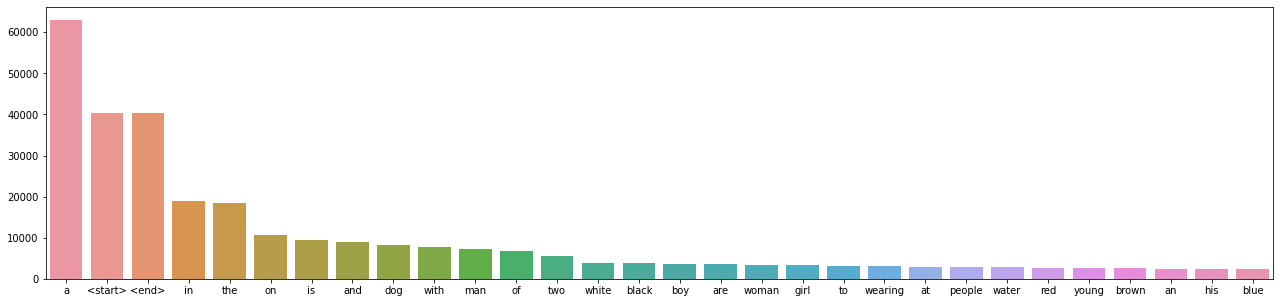

In [14]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
word_count = tokenizer_words.word_counts
word_count = sorted(word_count.items(), key = operator.itemgetter(1),reverse=True)
word_list=(list(zip(*word_count))[0])[:30]
count_list=(list(zip(*word_count))[1])[:30]

plt.figure(figsize=(22,5))
sns.barplot(x=list(word_list),y=list(count_list))

#your code here

In [15]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [16]:
max_length=calc_max_length(train_seqs)
print('Max Length Of the sequence is : {}'.format(max_length))

Max Length Of the sequence is : 39


In [17]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')#your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [18]:
#write your code here to create the dataset consisting of image paths
img_train = sorted(set(all_img_vector))

In [19]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img,3)
    img = tf.image.resize(img,(299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img,image_path

In [20]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
batch_size= 64
img_dataset = tf.data.Dataset.from_tensor_slices(img_train)
img_dataset = img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)



In [21]:
img_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [25]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input#write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output#write code here to get the output of the image_model

image_features_extract_model = keras.Model(new_input,hidden_layer)#build the final model using both input & output layer

In [26]:
image_features_extract_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [28]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
feature_dict={}

for image,path in tqdm(img_dataset):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()


100%|██████████| 127/127 [01:21<00:00,  1.55it/s]


In [30]:
batch_f.shape

TensorShape([64, 2048])

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [34]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)
#your code goes here

In [35]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [36]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
# your input variable goes here
def map_func(image_name,capt):
  img_tensor = feature_dict[image_name.decode('utf-8')]# write your code here to extract the features from the dictionary stored earlier
  return img_tensor,capt

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [42]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data):
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # your code goes here to create the dataset & transform it
    return dataset



In [43]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [44]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [46]:
embedding_dim = 256 
units = 512
vocab_size = 5001#top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [49]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5) #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)  # extract the features from the image shape: (batch, 8*8, embed_dim)
        return features

In [52]:
encoder=Encoder(embedding_dim)

In [80]:
class RNN_Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### Attention model

In [53]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)#build your Dense layer
        self.W2 = layers.Dense(units)#build your Dense layer
        self.V = layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features#shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [64]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)   
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) 
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [65]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [66]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer_words.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [67]:
optimizer = keras.optimizers.Adam()#define the optimizer
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [68]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [70]:
checkpoint_path = "/content/models/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [71]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [90]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer_words.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))#write your code here to do the training steps
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [97]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer_words.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [95]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [98]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()



  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.861, & test loss is 0.906
Time taken for 1 epoch 175.76524877548218 sec

Test loss has been reduced from 100.000 to 0.906




  7%|▋         | 1/15 [02:56<41:04, 176.03s/it]

For epoch: 2, the train loss is 0.801, & test loss is 0.831
Time taken for 1 epoch 127.83698105812073 sec

Test loss has been reduced from 0.906 to 0.831




 13%|█▎        | 2/15 [05:04<35:01, 161.64s/it]

 20%|██        | 3/15 [07:12<30:19, 151.60s/it]

For epoch: 3, the train loss is 0.753, & test loss is 0.773
Time taken for 1 epoch 127.98657464981079 sec

Test loss has been reduced from 0.831 to 0.773




 27%|██▋       | 4/15 [09:20<26:30, 144.56s/it]

For epoch: 4, the train loss is 0.710, & test loss is 0.727
Time taken for 1 epoch 127.92672896385193 sec

Test loss has been reduced from 0.773 to 0.727




 33%|███▎      | 5/15 [11:28<23:17, 139.71s/it]

For epoch: 5, the train loss is 0.672, & test loss is 0.684
Time taken for 1 epoch 128.1899073123932 sec

Test loss has been reduced from 0.727 to 0.684
For epoch: 6, the train loss is 0.637, & test loss is 0.647
Time taken for 1 epoch 128.05560851097107 sec

Test loss has been reduced from 0.684 to 0.647




 40%|████      | 6/15 [13:37<20:26, 136.28s/it]

 47%|████▋     | 7/15 [15:45<17:51, 133.90s/it]

For epoch: 7, the train loss is 0.604, & test loss is 0.612
Time taken for 1 epoch 128.1354649066925 sec

Test loss has been reduced from 0.647 to 0.612


For epoch: 8, the train loss is 0.575, & test loss is 0.580
Time taken for 1 epoch 128.21162962913513 sec

Test loss has been reduced from 0.612 to 0.580


 53%|█████▎    | 8/15 [17:53<15:25, 132.26s/it]

For epoch: 9, the train loss is 0.547, & test loss is 0.550
Time taken for 1 epoch 127.99748706817627 sec

Test loss has been reduced from 0.580 to 0.550




 60%|██████    | 9/15 [20:02<13:06, 131.04s/it]

 67%|██████▋   | 10/15 [22:10<10:51, 130.25s/it]

For epoch: 10, the train loss is 0.522, & test loss is 0.526
Time taken for 1 epoch 128.21264576911926 sec

Test loss has been reduced from 0.550 to 0.526




 73%|███████▎  | 11/15 [24:18<08:38, 129.62s/it]

For epoch: 11, the train loss is 0.498, & test loss is 0.501
Time taken for 1 epoch 127.93351483345032 sec

Test loss has been reduced from 0.526 to 0.501




 80%|████████  | 12/15 [26:27<06:27, 129.30s/it]

For epoch: 12, the train loss is 0.476, & test loss is 0.478
Time taken for 1 epoch 128.35181307792664 sec

Test loss has been reduced from 0.501 to 0.478
For epoch: 13, the train loss is 0.458, & test loss is 0.460
Time taken for 1 epoch 128.1098129749298 sec

Test loss has been reduced from 0.478 to 0.460




 87%|████████▋ | 13/15 [28:35<04:18, 129.01s/it]

 93%|█████████▎| 14/15 [30:43<02:08, 128.80s/it]

For epoch: 14, the train loss is 0.440, & test loss is 0.440
Time taken for 1 epoch 128.11638188362122 sec

Test loss has been reduced from 0.460 to 0.440




100%|██████████| 15/15 [32:52<00:00, 128.68s/it]

For epoch: 15, the train loss is 0.423, & test loss is 0.424
Time taken for 1 epoch 128.19905972480774 sec

Test loss has been reduced from 0.440 to 0.424


100%|██████████| 15/15 [32:52<00:00, 131.48s/it]


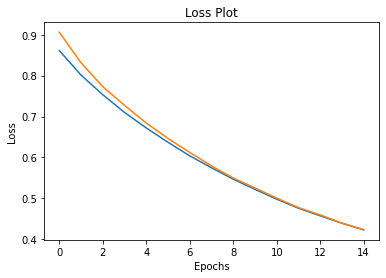

In [99]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [101]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer_words.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer_words.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer_words.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [136]:
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer_words.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer_words.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer_words.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [117]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [113]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [102]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score: 33.33333333333333
Real Caption: a small child looks and smiles as she eats
Prediction Caption: a little boy has bubbles which is eating something


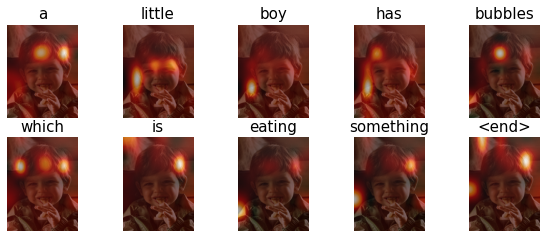

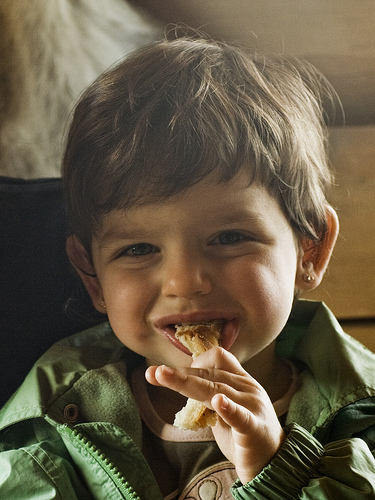

In [122]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer_words.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [137]:
captions=beam_evaluate(test_image)
print(captions)

a young boy has his face
